In [1]:
import tensorflow as tf 
import os
import matplotlib.pyplot as plt 
import numpy as np
import cv2
import imghdr # check file extensions for images
import hashlib
import sys


2025-08-02 22:29:46.700008: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/_6/9qy9h4dj5s77xvnptfkf0yrw0000gp/T/ipykernel_1356/2868669117.py:6: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr # check file extensions for images


In [29]:
from src.preprocessing import *
from src.model import *


In [2]:
# Add the parent directory to the system path
sys.path.append(os.path.abspath('..'))

In [ ]:
"""remove duplicate files from train and test sets if any """
import os
import hashlib
# Paths
base = "../data"  # or 'dataset' or whatever your base folder is

find_and_remove_duplicates(os.path.join(base, 'train/happy'), os.path.join(base, 'test/happy'))
find_and_remove_duplicates(os.path.join(base, 'train/sad'), os.path.join(base, 'test/sad'))


✅ Removed 0 duplicate(s) from: ../data/test/happy
✅ Removed 0 duplicate(s) from: ../data/test/sad


In [ ]:
"""delete macbook DS_Store files"""
delete_ds_store("../data")



✅ Deleted 0 .DS_Store file(s).


In [ ]:
"""Remove unauthorized image extensions in training set and test set """
remove_unauthorized_extensions('../data/train')
remove_unauthorized_extensions('../data/test')


In [7]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)
Source:   
@keras_export(
    [
        "keras.utils.image_dataset_from_directory",
        "keras.preprocessing.image_dataset_from_directory",
    ]
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    ve

In [8]:
# batch load data pipeline  with batch size set to 32, uniform resizing, labels mapped and data shuffled.
train_data = tf.keras.utils.image_dataset_from_directory('../data/train', seed=42)

val_data = tf.keras.utils.image_dataset_from_directory(
    '../data/test', shuffle=True, subset="validation", seed=123, validation_split=0.5
    )

test_data = tf.keras.utils.image_dataset_from_directory(
   '../data/test', shuffle=True, seed=123, subset='training', validation_split=0.5
)

Found 169 files belonging to 2 classes.
Found 144 files belonging to 2 classes.
Using 72 files for validation.
Found 144 files belonging to 2 classes.
Using 72 files for training.


In [9]:
print(train_data.class_names)

['happy', 'sad']


In [ ]:
batch = display(train_data)
batch[0]

array([[[[255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ],
         ...,
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ]],

        [[255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ],
         ...,
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ]],

        [[255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ],
         ...,
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ],
         [255.       , 255.       , 255.       ]],

        ...,

        [[255.       , 255.       , 25

In [11]:
batch[0].shape

(32, 256, 256, 3)

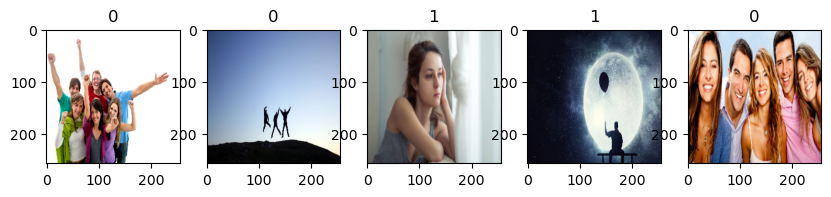

In [12]:
# Class 1 = sad, Class 0 = Happy
fig, ax = plt.subplots(ncols=5, figsize=(10, 10))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [13]:
type(train_data)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [14]:
for images, labels in train_data.take(1):
    print("Min pixel value:", tf.reduce_min(images))
    print("Max pixel value:", tf.reduce_max(images))

Min pixel value: tf.Tensor(0.0, shape=(), dtype=float32)
Max pixel value: tf.Tensor(255.0, shape=(), dtype=float32)


2025-08-02 22:30:12.375290: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
# add random horizontal flip, normalization, random_brightness change, random rotation 
from src.preprocessing import augment_images, normalize_image
train_data = train_data.map(augment_images)
test_data = test_data.map(normalize_image)
val_data = val_data.map(normalize_image)


In [16]:
data_iterator = train_data.as_numpy_iterator()
batch = data_iterator.next()
batch[0]

array([[[[4.38908309e-01, 3.26714665e-01, 3.30804735e-01],
         [3.95343870e-01, 2.20052823e-01, 1.97365925e-01],
         [5.75459301e-01, 3.49034697e-01, 2.96844125e-01],
         ...,
         [4.55401242e-01, 4.75009084e-01, 4.90695357e-01],
         [4.58572507e-01, 4.78180349e-01, 4.93866622e-01],
         [4.51586902e-01, 4.71194744e-01, 4.86881018e-01]],

        [[4.63647515e-01, 3.40654254e-01, 3.31784785e-01],
         [6.20680213e-01, 4.47456270e-01, 4.09557074e-01],
         [6.77455604e-01, 4.60134715e-01, 3.96680474e-01],
         ...,
         [4.54924881e-01, 4.74532723e-01, 4.90218997e-01],
         [4.64071602e-01, 4.83679444e-01, 4.99365717e-01],
         [4.62309957e-01, 4.81917799e-01, 4.97604072e-01]],

        [[6.18800700e-01, 4.86999214e-01, 4.67559874e-01],
         [7.70369828e-01, 5.98831832e-01, 5.48525453e-01],
         [7.93130696e-01, 5.83234847e-01, 5.10593891e-01],
         ...,
         [4.57147568e-01, 4.76755410e-01, 4.92441684e-01],
         [

In [17]:
for images, labels in train_data.take(1):
    print("Min pixel value:", tf.reduce_min(images))
    print("Max pixel value:", tf.reduce_max(images))

Min pixel value: tf.Tensor(0.0007037227, shape=(), dtype=float32)
Max pixel value: tf.Tensor(1.0007037, shape=(), dtype=float32)


2025-08-02 22:30:14.933941: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
"""define and train model with keras tuner for extensive hyperparameter tuning(find functions in src/model.py)"""
import keras_tuner as kt 
tuner = create_tuner()
model = train_model(train_data, val_data, tuner)


Trial 20 Complete [00h 12m 45s]
val_accuracy: 0.8055555820465088

Best val_accuracy So Far: 0.8333333134651184
Total elapsed time: 03h 33m 47s


/opt/anaconda3/envs/data_env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


AttributeError: 'RandomSearch' object has no attribute 'get_best_hyerparameter'

In [28]:
model_evaluation(model, test_data)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step


2025-08-03 07:31:05.254089: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

           0       0.43      0.47      0.45        32
           1       0.54      0.50      0.52        40

    accuracy                           0.49        72
   macro avg       0.48      0.48      0.48        72
weighted avg       0.49      0.49      0.49        72

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 376ms/step - accuracy: 0.7079 - loss: 0.8878
Test Loss: 0.7906179428100586
Test Accuracy: 0.7361111044883728


In [ ]:
model.save('../models/emotion_model.keras')